In [1]:
write_images = False


wirte_output_txt = False 
# Specify everytime Simulation is called 
# WARNING --> Set to False when running more then 10 simulations 
#            (otherwise it will be super slow and might crash)

In [2]:
import numpy as np

In [3]:
from emukit.core import ContinuousParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign

import GPy
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity

import matplotlib.pyplot as plt
import mlai.plot as plot

In [4]:
%run Missile_utils.ipynb

In [5]:
simulation_output = 'range' # For now only this is implemented
# We divide by 1000 to avoid dealing with too large numbers

In [6]:
run_grid_simulation = True # If true takes much longer and does 3D plots and so on for MODEL with 2 FEATS


We consider missiles with only 1 stage

In [7]:

basic_param_spaces = {
    'payload':  [10, 2410],
    'missilediam':  [0.1, 9.9],
    'rvdiam':  [0.1, 9.9],
    'estrange': [100, 4900], 
    'fuelmass': [500, 6000], # [500, 6000], 
    'drymass':  [1000, 3000],
    'Isp0':  [100, 800],# [100, 800],
    'thrust0':  [10000, 69000],
}

In [8]:
from sklearn.metrics import mean_squared_error
import math

# TODO: improve considering also the variance 
# (i.e. penalise less if mean prediction is not accurate, but still within 2 std dev?)
def compute_rmse(y_actual, y_predicted):
    MSE = mean_squared_error(y_actual, y_predicted)
    RMSE = math.sqrt(MSE)
 
    return RMSE

def evaluate_prediction(y_actual, y_predicted):
    return compute_rmse(y_actual, y_predicted)
    
    

# 1. Two params

In [9]:
m2_param_1 = 'fuelmass'
m2_domain_param_1 = basic_param_spaces[m2_param_1] # [500, 6000] # [5000,15000]
m2_param_2 = 'Isp0'
m2_domain_param_2 = basic_param_spaces[m2_param_2] # [200, 300] # [224, 228]

m2_space = ParameterSpace(
          [ContinuousParameter(m2_param_1, *m2_domain_param_1), 
           ContinuousParameter(m2_param_2, *m2_domain_param_2),
#            ContinuousParameter(param_3, *domain_param_3),
#            ContinuousParameter(param_4, *domain_param_4)
          ])

custom_param_names = [m2_param_1, m2_param_2]

In [10]:
# Can receive only one parameter x, so will read custom_param_names and simulation_output from globals
# (Not nice, but works)

# This is our TARGET FUNCTION (Re-run since custom_param_names has changed)
def run_missile_sim(custom_params):
    """
    Recives in input an array of custom parameters.
    Each row represents a set of different parameters
    Each column is a different parameter (#cols = len(custom_param_names))
    """
    default_params_IRAQ = {
        'payload':500,
        'missilediam':0.88,
        'rvdiam':0,
        'estrange':600,
        'numstages':1,
        'fuelmass':[0,5600],
        'drymass':[0,1200],
        'Isp0':[0,226],
        'thrust0':[0,9177.4]
    }
    
    
    y = np.zeros((custom_params.shape[0], 1))
    for i in range(custom_params.shape[0]):
        params_to_use = default_params_IRAQ
        # Overwrite default param variables
        for j in range(custom_params.shape[1]):
            param_name = custom_param_names[j]
            if param_name in ['fuelmass', 'drymass', 'Isp0', 'thrust0']:
                params_to_use[param_name][1] = custom_params[i,j] # OK as long as we are considering missiles with only 1 stage
            else:
                params_to_use[param_name] = custom_params[i, j]
                
            ## TEMP ## Better customise this
            if j==0:
                print('\nNew simulation \n')
            str_to_print = param_name + ': ' + str(custom_params[i,j])
            print(str_to_print)
            ## 
                
        # Run simulation
        output_path = 'results/results_' + str(i) + '.txt' # TODO Define better identifier
        sim_output = run_one_sim(
            numstages=params_to_use["numstages"], 
            fuelmass=params_to_use["fuelmass"], 
            drymass=params_to_use["drymass"], 
            thrust0=params_to_use["thrust0"], 
            Isp0=params_to_use["Isp0"], 
            payload=params_to_use["payload"],  
            missilediam=params_to_use["missilediam"],  
            rvdiam=params_to_use["rvdiam"], 
            est_range=params_to_use["estrange"], 
            output_path=output_path, 
            simulation_output=simulation_output,
        )
        
        y[i, 0] = sim_output
    return y


def neg_run_missile_sim(custom_params):
    return -run_missile_sim(custom_params)
    
    

## 1. Experimental design

Experimental design addresses the problem of how to collect data points (experiments) to better control certain sources of variance of a model.

In experimental design the goal is to decide at which locations of the input space we should evaluate a function of interest. In some contexts it is also known as active learning, for instance in image classification problems in which more labels need to be collected.

The are two main ways of doing experimental design.

1. Model-free designs: These designs define rules to spread the experiments as much as possible across the input domain. Drawing points at random or in a grid are the most naive way of doing so. Other more elaborate approaches are low discrepancy sequences that try to induce some negative correlation in the selected points to spread them evenly. Some examples are Latin hyper-cube sampling and Sobol sequences.

2. Model-based designs: In these designs a feedback loop is used between some ‘optimal’ statistical criterion to collect points and a model. In general, the criterion aims to reduce some type of variance in the model. The type of optimality refers to which type of uncertainty that is reduced. For instance, a D-optimal design aims to maximize the differential Shannon information content of the model parameter estimates; an I-optimal design seeks to minimize the average prediction variance over the entire design space. 

Gaussian processes have a long tradition of being the ‘model of choice’ for designing experiments.

### Use model-free experimental design to start
 (RandomDesign or Latin Design)


New simulation 

fuelmass: 2344.272801823478
Isp0: 133.69049061923096


Stage 1 burnout
Velocity (km/s):  0.7308163063500095
Angle (deg h):  43.674949978763244
Range (km):  5.0716340489588365
Time (sec):  34.200000000000216
Final results: 
Range (km):  67.9043671493226
Apogee (km):  21.93600119834042
Time to target (sec):  153.49999999999557




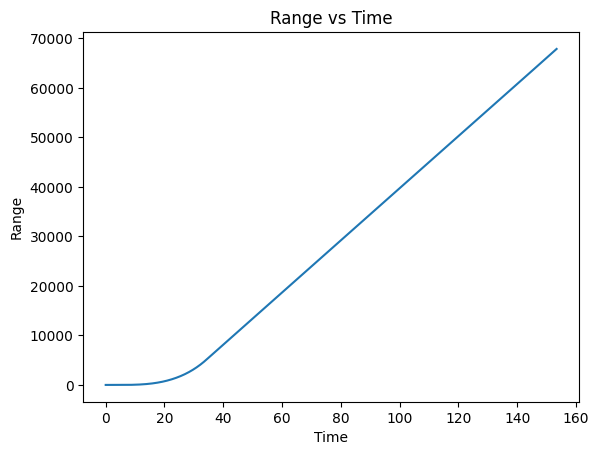

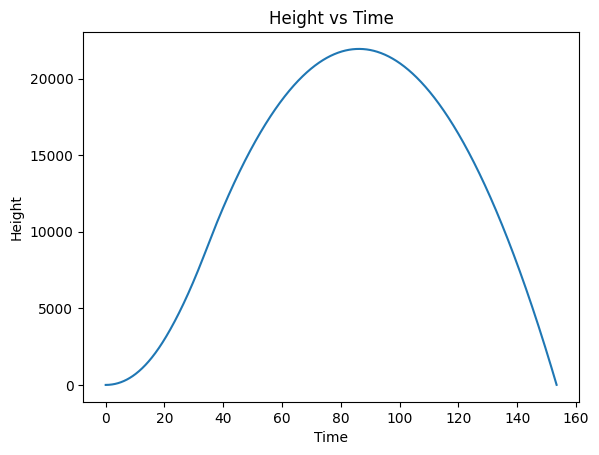

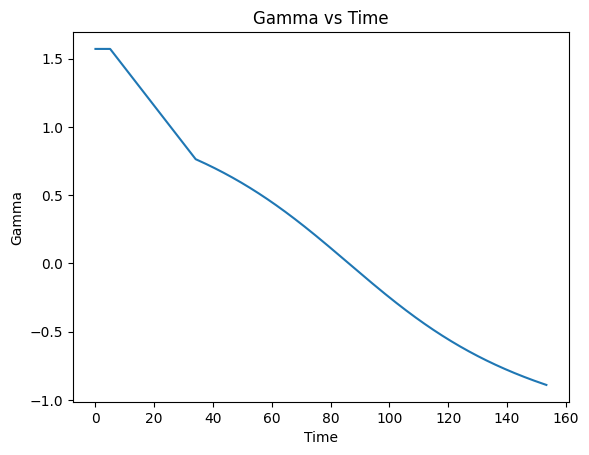

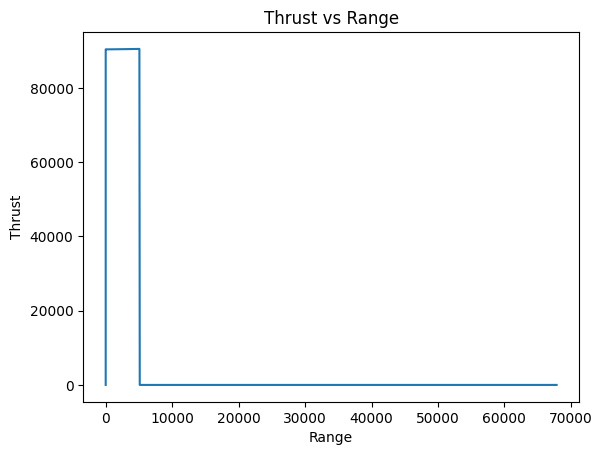

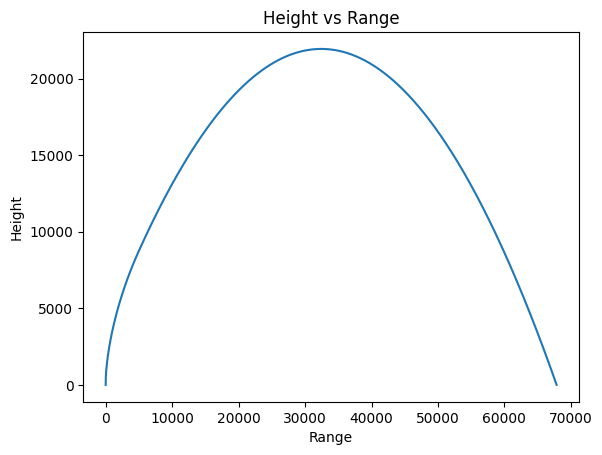

Data written to 'results/results_0.txt'

New simulation 

fuelmass: 690.0696727783791
Isp0: 385.3214675865679


Stage 1 burnout
Velocity (km/s):  0.8695346520943245
Angle (deg h):  43.74623063585708
Range (km):  5.579806694181671
Time (sec):  29.000000000000146
Final results: 
Range (km):  93.02692964933328
Apogee (km):  29.19645634645156
Time to target (sec):  168.8999999999947




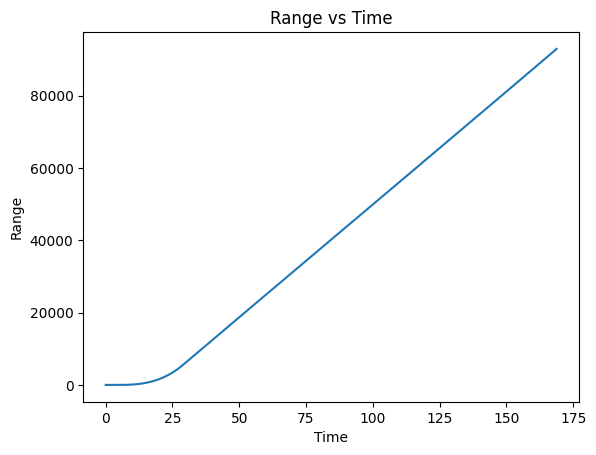

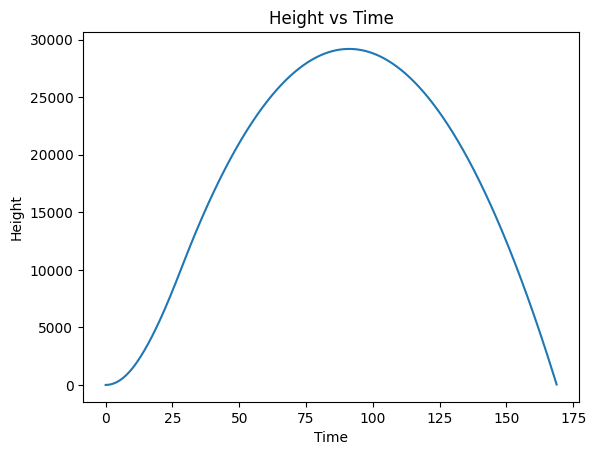

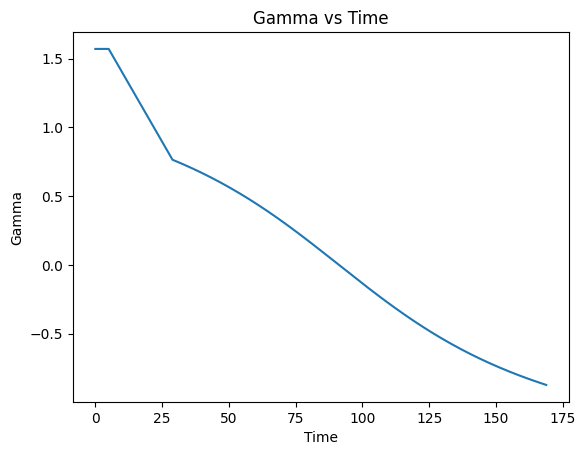

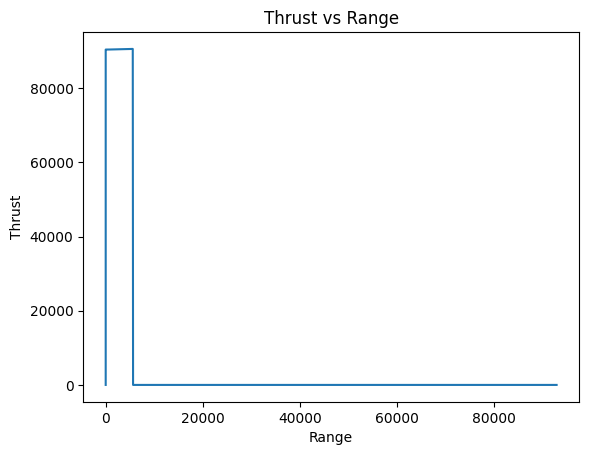

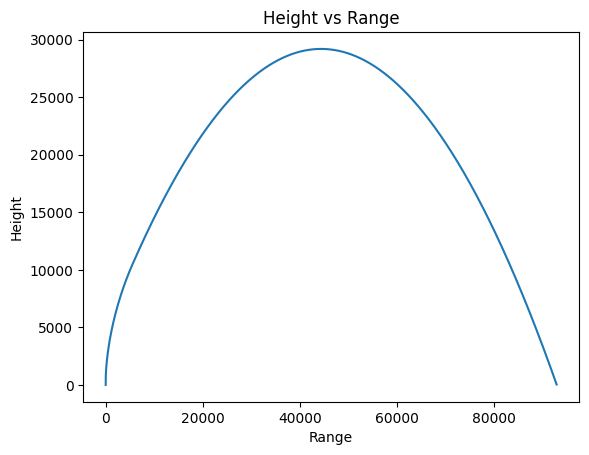

Data written to 'results/results_1.txt'

New simulation 

fuelmass: 3864.3642325245464
Isp0: 646.3738158816806


Stage 1 burnout
Velocity (km/s):  6.084822153343476
Angle (deg h):  43.661004407867985
Range (km):  283.3198990862409
Time (sec):  272.1999999999934
Final results: 
Range (km):  6340.346450641081
Apogee (km):  2293.137629389886
Time to target (sec):  2257.1999999990426




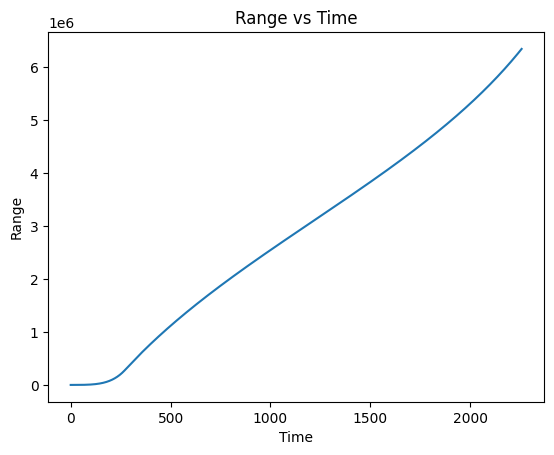

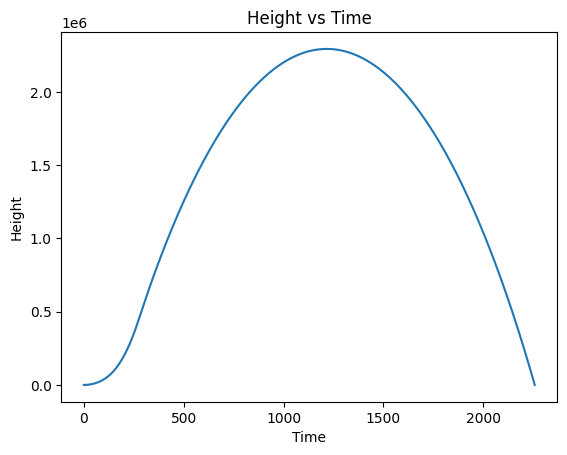

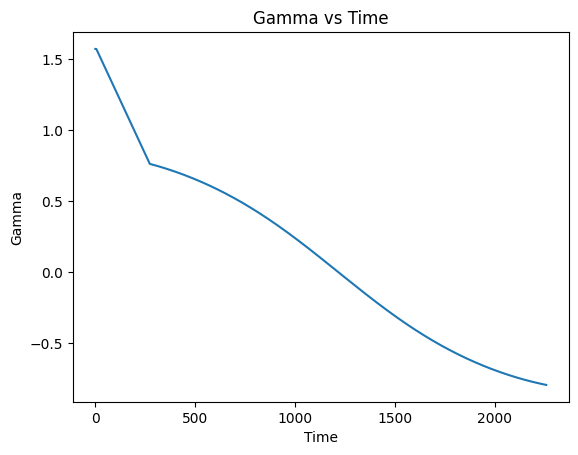

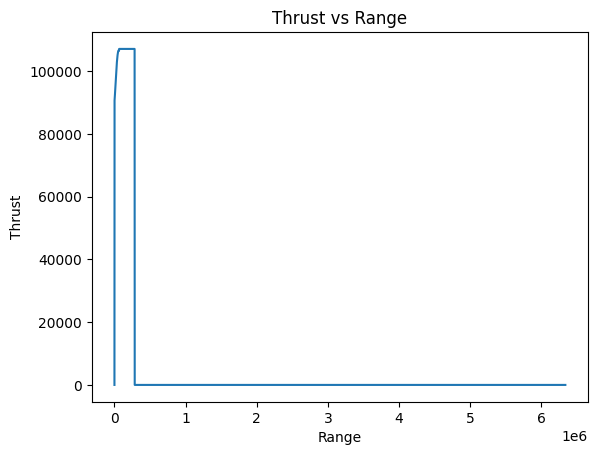

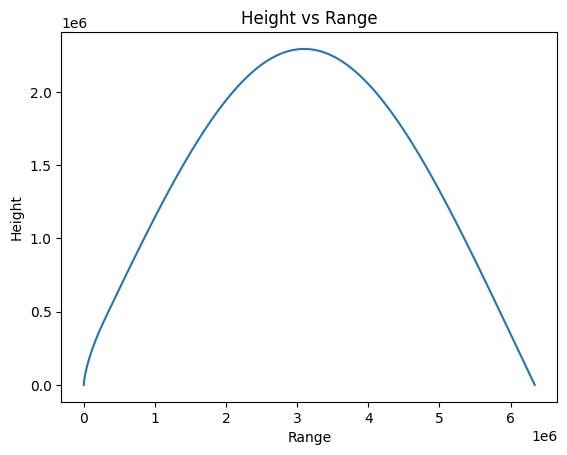

Data written to 'results/results_2.txt'

New simulation 

fuelmass: 2262.755004410195
Isp0: 798.2429229490475


Stage 1 burnout
Velocity (km/s):  5.594659391746572
Angle (deg h):  43.653856075828486
Range (km):  209.42976088037125
Time (sec):  196.7999999999931
Final results: 
Range (km):  4980.120879020318
Apogee (km):  1687.6950743298084
Time to target (sec):  1755.6999999994987




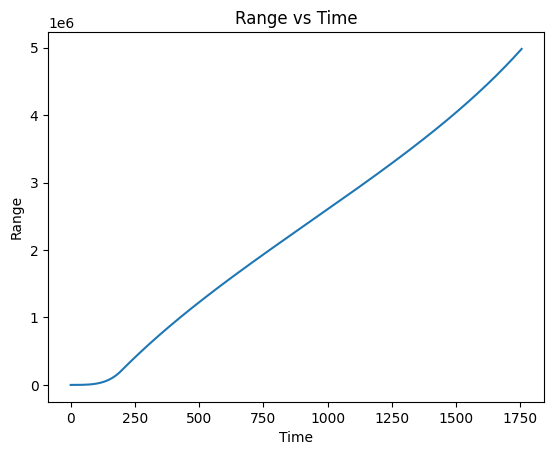

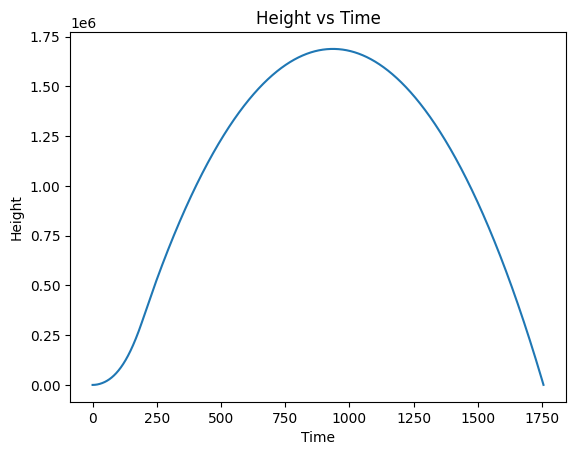

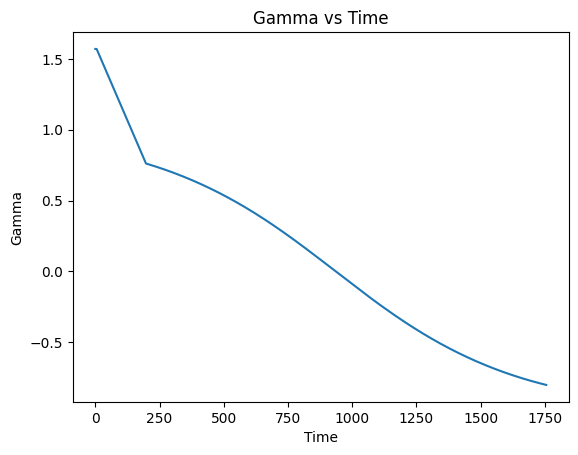

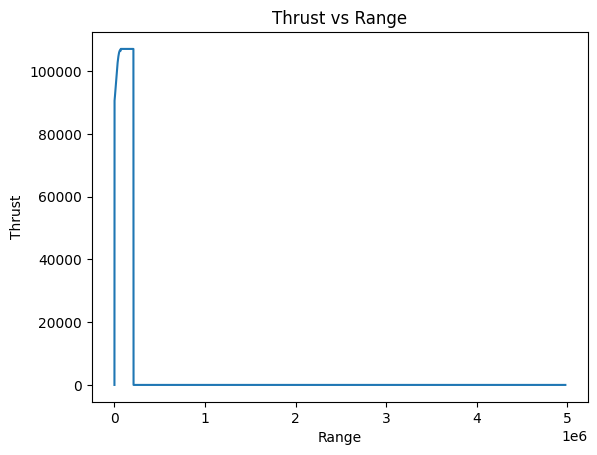

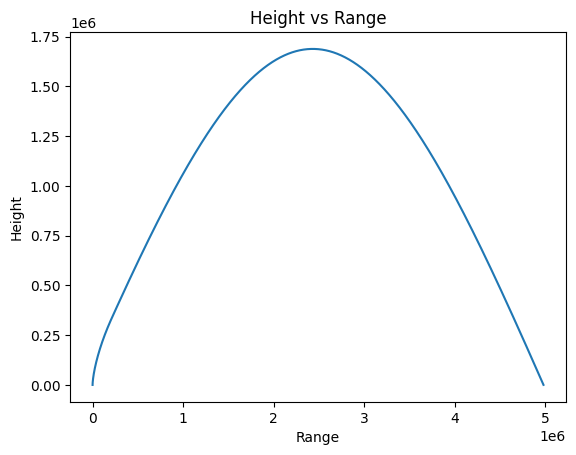

Data written to 'results/results_3.txt'

New simulation 

fuelmass: 5114.695994168096
Isp0: 413.2739267606555


Stage 1 burnout
Velocity (km/s):  4.127010876604467
Angle (deg h):  43.64901518722537
Range (km):  149.99545149569752
Time (sec):  230.3999999999912
Final results: 
Range (km):  2447.7774470776544
Apogee (km):  780.6561002567238
Time to target (sec):  1107.4000000000883




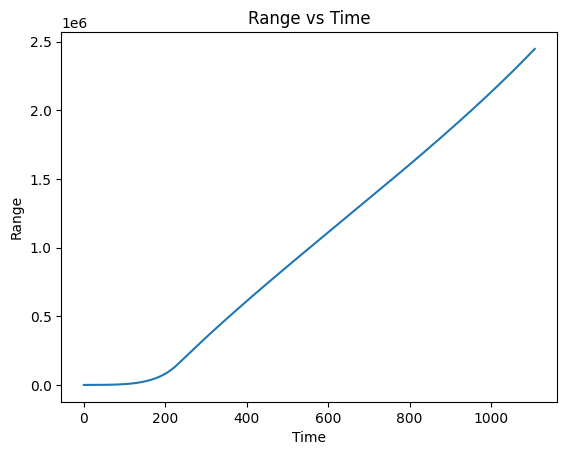

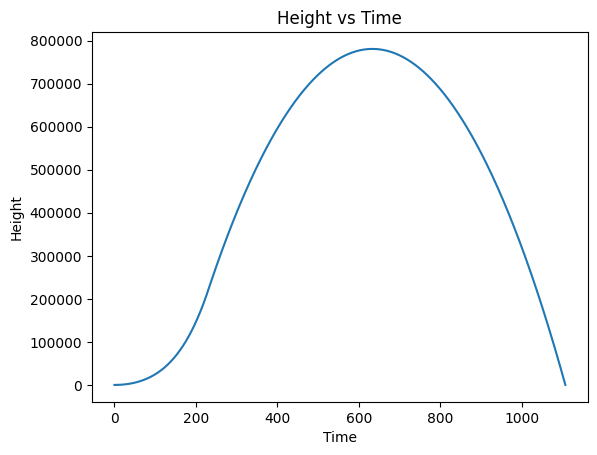

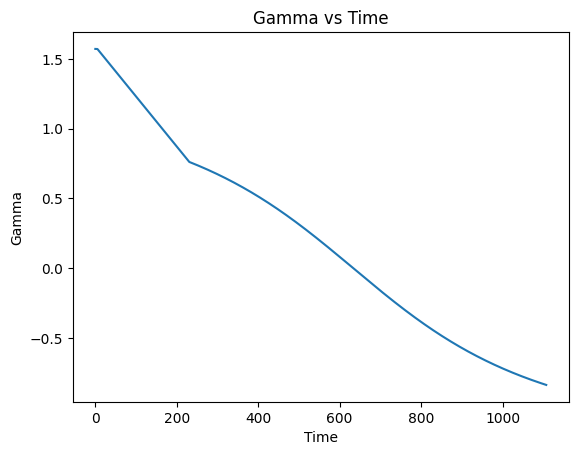

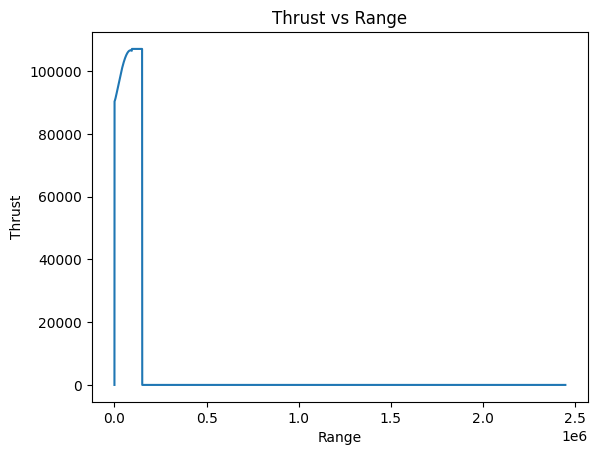

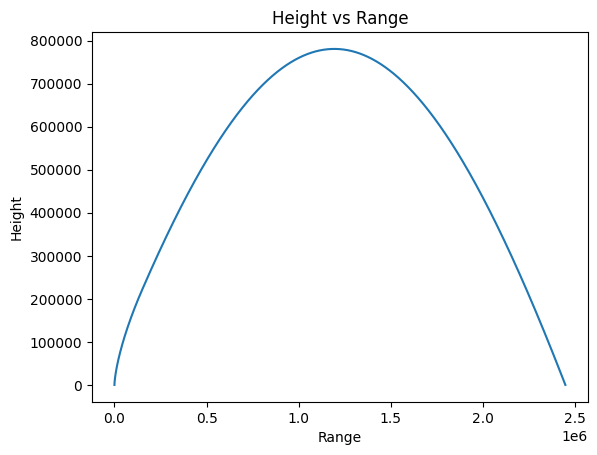

Data written to 'results/results_4.txt'

New simulation 

fuelmass: 2183.9002483335644
Isp0: 586.3516202219057


Stage 1 burnout
Velocity (km/s):  3.7924544483125437
Angle (deg h):  43.65374817019952
Range (km):  101.85185986584578
Time (sec):  139.59999999999636
Final results: 
Range (km):  1961.1341056254817
Apogee (km):  607.4732034673677
Time to target (sec):  891.7000000001342




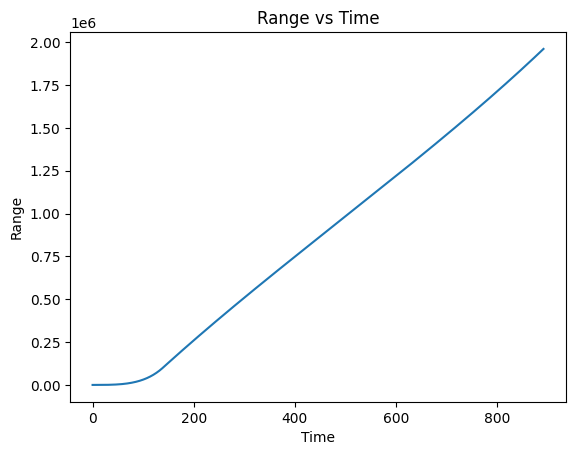

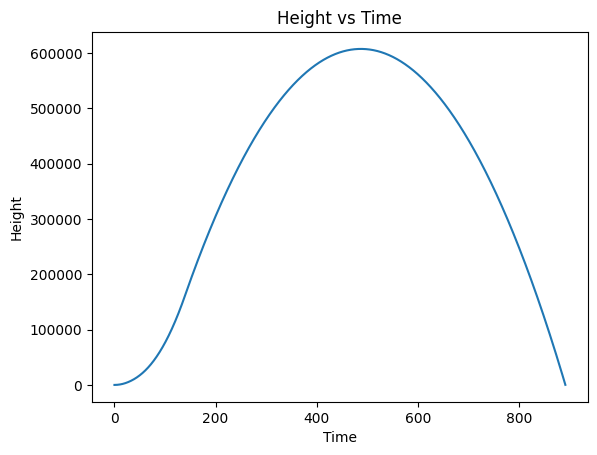

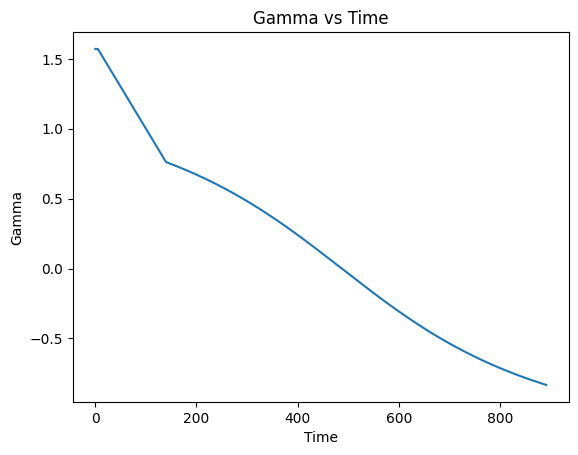

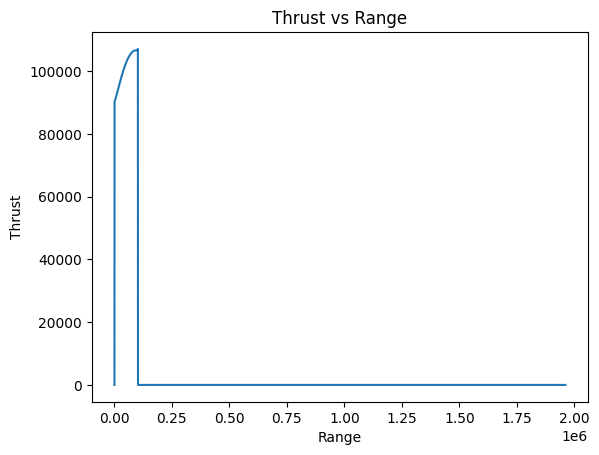

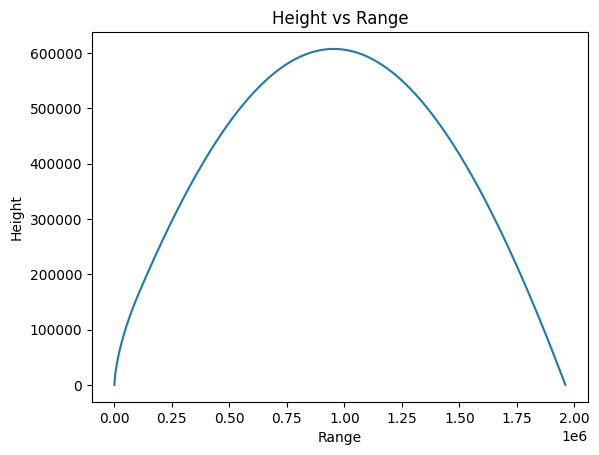

Data written to 'results/results_5.txt'


In [11]:
wirte_output_txt = True


# from emukit.core.initial_designs.latin_design import LatinDesign
# design = LatinDesign(parameter_space) 

m2_design = RandomDesign(m2_space)
m2_x = m2_design.get_samples(3*2)
m2_y = neg_run_missile_sim(m2_x)

In [12]:
# Build model
m2_var_kernel = (100)**2 
m2_lengthscale = 100 # 100 # 1
# In catapult: RBF kernel is set to 150^2 because that’s roughly the square of the range of the catapult
m2_var_noise = 1e-5 # small value
# In catapult: 1e-5

#kern = GPy.kern.RBF(input_dim=2, lengthscale=lengthscale, variance =var_kernel)  # , lengthscale=0.08, variance=20
# kern = GPy.kern.Matern32(input_dim=1)
# kern = GPy.kern.Linear(input_dim=1)

constrain_lengthscale = True

m2_rbf_kern = GPy.kern.RBF(input_dim=2, lengthscale=m2_lengthscale)
if constrain_lengthscale:
    m2_rbf_kern.lengthscale.constrain_bounded(m2_lengthscale, m2_lengthscale*1e12)

# m2_kern = m2_rbf_kern + \
#     GPy.kern.Linear(input_dim=2)
m2_kern = (GPy.kern.RBF(input_dim=2, lengthscale=500) * \
           GPy.kern.RBF(input_dim=2, lengthscale=100)) * \
    GPy.kern.Linear(input_dim=2)
# m2_kern = m2_rbf_kern

m2_model_gpy = GPRegression(m2_x,m2_y, kernel=m2_kern)
m2_model_gpy.kern.variance =  m2_var_kernel 
m2_model_gpy.likelihood.variance.fix(m2_var_noise)  

# Add constraints ?
# Add priors ?
# Change Kernel
# Change variances values

display(m2_model_gpy)




reconstraining parameters rbf.lengthscale


GP_regression.,value,constraints,priors
mul.rbf.variance,1.0,+ve,
mul.rbf.lengthscale,500.0,+ve,
mul.rbf_1.variance,1.0,+ve,
mul.rbf_1.lengthscale,100.0,+ve,
mul.linear.variances,1.0,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [13]:
# m2_model_gpy_opt = m2_model_gpy
# m2_model_gpy_opt.optimize()
# m2_model_gpy_opt.plot()

In [14]:
m2_model_emukit = GPyModelWrapper(m2_model_gpy)
m2_model_emukit.optimize()

In [15]:
display(m2_model_gpy)

GP_regression.,value,constraints,priors
mul.rbf.variance,1.068437986158809,+ve,
mul.rbf.lengthscale,501.09378524764657,+ve,
mul.rbf_1.variance,1.068437986158809,+ve,
mul.rbf_1.lengthscale,236.60886268194253,+ve,
mul.linear.variances,1.0684379861589035,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [16]:
# Create data for plot
wirte_output_txt = False
nr_points_plot = 101
m2_param_1_x_plot = np.linspace(m2_space.parameters[0].min, m2_space.parameters[0].max, nr_points_plot)[:, None]
m2_param_2_x_plot = np.linspace(m2_space.parameters[1].min, m2_space.parameters[1].max, nr_points_plot)[:, None]
m2_x_plot_mesh, m2_y_plot_mesh = np.meshgrid(m2_param_1_x_plot, m2_param_2_x_plot)
m2_x_plot = np.array([m2_x_plot_mesh, m2_y_plot_mesh]).T.reshape(-1,2)


# TEMP read data from txt
# np.savetxt('test1.txt', a, fmt='%f')
m2_y_plot = np.loadtxt('m2_y_plot_neg.txt', dtype=float)[:,None]

if run_grid_simulation:
#     m2_y_plot = neg_run_missile_sim(m2_x_plot) # TAKES LONG TIME    
    m2_Z = m2_y_plot.reshape(m2_x_plot_mesh.shape)




In [17]:
m2_x

array([[2344.27280182,  133.69049062],
       [ 690.06967278,  385.32146759],
       [3864.36423252,  646.37381588],
       [2262.75500441,  798.24292295],
       [5114.69599417,  413.27392676],
       [2183.90024833,  586.35162022]])

In [18]:
# Compute current prediction
m2_mu_plot_grid_pred1, var_plot_grid_pred1 = m2_model_emukit.predict(m2_x_plot)
m2_mu_plot_pred1 = m2_mu_plot_grid_pred1.reshape(m2_x_plot_mesh.shape)
m2_var_plot_pred1 = var_plot_grid_pred1.reshape(m2_x_plot_mesh.shape)

if run_grid_simulation:
    m2_rmse = evaluate_prediction(y_actual=m2_y_plot, y_predicted=m2_mu_plot_grid_pred1)
    print("RMSE m2 (before experiment design loop): ", m2_rmse)


RMSE m2 (before experiment design loop):  4214.4978863029355


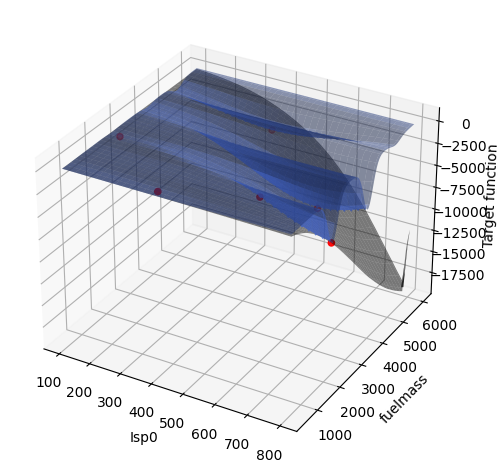

In [19]:
if run_grid_simulation:
    # 3D Plot
    add_bands = False


#     fig = plt.figure()
#     ax = fig.add_subplot(projection='3d')

#     # True surface
#     surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_Z, 
#                            alpha = .5, 
#                            label='target function',
#                            color='black'
#                           )
#     # Mean predicted
#     surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1, 
#                            alpha = .5, 
#                            label='model', # Mean
#                            color='royalblue'
#                           )
#     # True points observed
#     m2_x_mesh, m2_y_mesh = np.meshgrid(m2_x[:,0], m2_x[:,1])
#     ax.scatter(m2_x[:,0], m2_x[:,1], m2_y, marker='o', color='red')

#     if add_bands:
#         surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1-2*m2_var_plot_pred1, 
#                                alpha = .5, 
#                                label='model_ci_lb', # Confidence band lower bound
#                                color='lightskyblue'
#                               )
#         surf = ax.plot_surface(m2_x_plot_mesh, m2_y_plot_mesh, m2_mu_plot_pred1+2*m2_var_plot_pred1, 
#                                alpha = .5, 
#                                label='model_ci_ub', # Confidence band upper bound
#                                color='lightskyblue' 
#                               )
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     ax.set_zlabel('Target function')
#     plt.tight_layout()
    
    # REVERSE
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # True surface
    surf = ax.plot_surface(m2_y_plot_mesh, m2_x_plot_mesh, (m2_Z).transpose(), 
                           alpha = .5, 
                           label='target function',
                           color='black'
                          )
    # Mean predicted
    surf = ax.plot_surface(m2_y_plot_mesh, m2_x_plot_mesh, (m2_mu_plot_pred1).transpose(), 
                           alpha = .5, 
                           label='model', # Mean
                           color='royalblue'
                          )
    # True points observed
    ax.scatter(m2_x[:,1], m2_x[:,0], m2_y, marker='o', color='red')

    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    ax.set_zlabel('Target function')
    plt.tight_layout()



 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_8056/1867888583.py:53: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_8056/1867888583.py:62: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_8056/1867888583.py:75: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


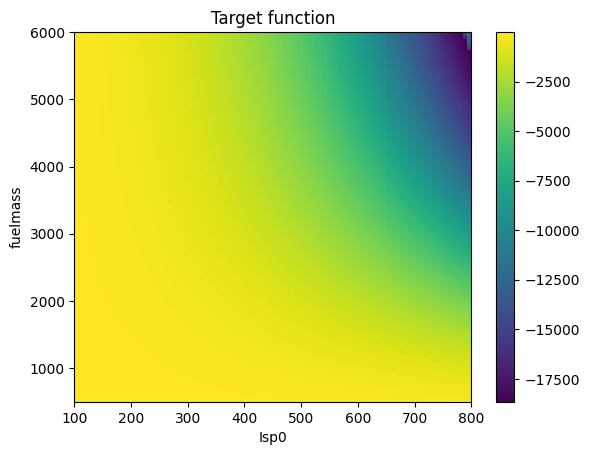

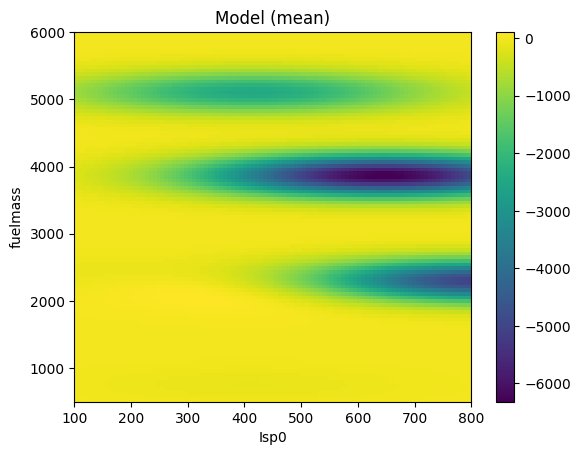

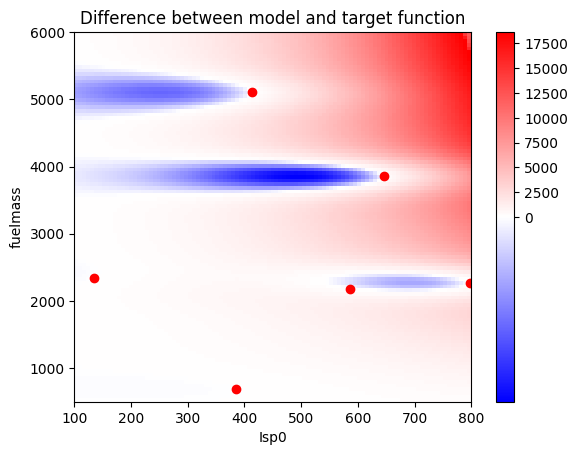

In [20]:
if run_grid_simulation:
    from matplotlib import colors
    divnorm=colors.TwoSlopeNorm(vcenter=0.) # vmin=-5., vcenter=0., vmax=10

#     # NORMAL
#     ## Heatmaps
#     extents = [m2_space.parameters[0].min, m2_space.parameters[0].max, 
#                m2_space.parameters[1].min, m2_space.parameters[1].max]

#     # True values
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_Z, extent=extents, aspect='auto')
#     ax.set_title('Target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()

#     # Model
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred1, extent=extents, aspect='auto')
#     ax.set_title('Model (mean)')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()


#     # Difference
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred1-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm)
#     ax.set_title('Difference between model and target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     # Add points where simulation evaluated
#     ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
# #     ax.plot(m2_x[:,1], m2_x[:,0], 'ro')
#     fig.colorbar(im, ax=ax)
#     fig.show()

    # REVERSE
    ## Heatmaps
    extents = [m2_space.parameters[1].min, m2_space.parameters[1].max, 
               m2_space.parameters[0].min, m2_space.parameters[0].max]

    # True values
    fig, ax = plt.subplots()
    im = ax.imshow(m2_Z, extent=extents, aspect='auto',  origin='lower')
    ax.set_title('Target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()

    # Model
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred1, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Model (mean)')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()


    # Difference
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred1-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm, origin='lower')
    ax.set_title('Difference between model and target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    # Add points where simulation evaluated
#     ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
    ax.plot(m2_x[:,1], m2_x[:,0], 'ro')
    fig.colorbar(im, ax=ax)
    fig.show()



In [21]:
m2_x

array([[2344.27280182,  133.69049062],
       [ 690.06967278,  385.32146759],
       [3864.36423252,  646.37381588],
       [2262.75500441,  798.24292295],
       [5114.69599417,  413.27392676],
       [2183.90024833,  586.35162022]])

### Use the model created for model-based experimental design
use the model to decide which are the best points to collect using some data collection criteria (that we call acquisition).

In [22]:
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance


In [23]:
# help(ExperimentalDesignLoop)

 It is known that when using Gaussian processes, selecting points of maximum variance is equivalent to maximizing the mutual information between the model and the new set of points so using ModelVariance is a simple but mathematically grounded approach.
 
 Actually in this example we use IVR

In [24]:
m2_2_model_emukit = m2_model_emukit

In [25]:
wirte_output_txt = False

integrated_variance = IntegratedVarianceReduction(space=m2_space,
                                                  model=m2_2_model_emukit)
m2_ed = ExperimentalDesignLoop(space=m2_space, 
                            model=m2_2_model_emukit, 
                            acquisition = integrated_variance,
                            batch_size = 1) 

m2_ed.run_loop(user_function=neg_run_missile_sim, stopping_condition=10*2)




New simulation 

fuelmass: 5700.781663482297
Isp0: 453.3914784697253


Stage 1 burnout
Velocity (km/s):  4.785333071698253
Angle (deg h):  43.65204054666392
Range (km):  203.80481238387395
Time (sec):  281.69999999999555
Final results: 
Range (km):  3485.170962413052
Apogee (km):  1142.8800095518027
Time to target (sec):  1426.8999999997977



New simulation 

fuelmass: 4627.693062840034
Isp0: 487.04589213526657


Stage 1 burnout
Velocity (km/s):  4.794487906444971
Angle (deg h):  43.66380480780843
Range (km):  191.9344504681437
Time (sec):  245.59999999999033
Final results: 
Range (km):  3474.284749577937
Apogee (km):  1136.1873632390618
Time to target (sec):  1388.8999999998323



New simulation 

fuelmass: 5406.592503380505
Isp0: 631.6760627266451


Stage 1 burnout
Velocity (km/s):  6.8592800717824876
Angle (deg h):  43.65410887041827
Range (km):  392.0573082853586
Time (sec):  372.20000000001613
Final results: 
Range (km):  8934.03134232275
Apogee (km):  3686.8029129119577
Time to

 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1



New simulation 

fuelmass: 1514.4536665896605
Isp0: 260.515802133716


Stage 1 burnout
Velocity (km/s):  1.080427972155479
Angle (deg h):  43.72419867849954
Range (km):  9.86794919088887
Time (sec):  43.00000000000034
Final results: 
Range (km):  146.22910711387553
Apogee (km):  46.253451016469015
Time to target (sec):  218.99999999999184



New simulation 

fuelmass: 708.6692517602387
Isp0: 511.0650155409547


Stage 1 burnout
Velocity (km/s):  1.1902870923514681
Angle (deg h):  43.703520245487326
Range (km):  10.446400529497835
Time (sec):  39.50000000000029
Final results: 
Range (km):  174.57060800658726
Apogee (km):  54.184484573873576
Time to target (sec):  231.9999999999911



New simulation 

fuelmass: 1907.3635920038678
Isp0: 616.7478760214063


Stage 1 burnout
Velocity (km/s):  3.6259230348772293
Angle (deg h):  43.67262580155149
Range (km):  91.24732101372011
Time (sec):  128.199999999997
Final results: 
Range (km):  1768.112616265929
Apogee (km):  544.6459697959511
Time to t

In [26]:
m2_2_model_emukit.X.shape


(26, 2)

In [27]:
m2_2_model_emukit.__dict__

{'model': <GPy.models.gp_regression.GPRegression at 0x7f85e0bc3a60>,
 'n_restarts': 1}

In [28]:
m2_ed.__dict__

{'candidate_point_calculator': <emukit.core.loop.candidate_point_calculators.SequentialPointCalculator at 0x7f85f190a7a0>,
 'model_updaters': [<emukit.core.loop.model_updaters.FixedIntervalUpdater at 0x7f85f190a0b0>],
 'loop_state': <emukit.core.loop.loop_state.LoopState at 0x7f85f190bfd0>,
 'loop_start_event': Event([]),
 'iteration_end_event': Event([]),
 'model': <emukit.model_wrappers.gpy_model_wrappers.GPyModelWrapper at 0x7f85e0bc2890>}

In [29]:
if run_grid_simulation:
    # Compute new prediction
    m2_mu_plot_grid_pred2, var_plot_grid_pred2 = m2_2_model_emukit.predict(m2_x_plot)
    m2_mu_plot_pred2 = m2_mu_plot_grid_pred2.reshape(m2_x_plot_mesh.shape)
    m2_var_plot_pred2 = var_plot_grid_pred2.reshape(m2_x_plot_mesh.shape)
    
    m2_2_rmse = evaluate_prediction(y_actual=m2_y_plot, y_predicted=m2_mu_plot_grid_pred2)
    print("RMSE m2 (post experiment design loop): ", m2_2_rmse)




RMSE m2 (post experiment design loop):  161.28473645515322


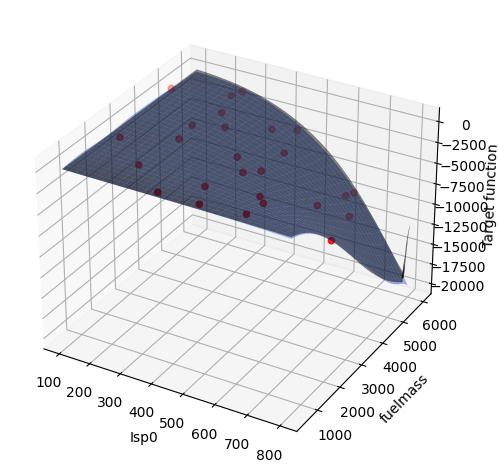

In [30]:
if run_grid_simulation:
    # 3D Plot
    add_bands = False

    
    # REVERSE
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # True surface
    surf = ax.plot_surface(m2_y_plot_mesh, m2_x_plot_mesh, (m2_Z).transpose(), 
                           alpha = .5, 
                           label='target function',
                           color='black'
                          )
    # Mean predicted
    surf = ax.plot_surface(m2_y_plot_mesh, m2_x_plot_mesh, (m2_mu_plot_pred2).transpose(), 
                           alpha = .5, 
                           label='model', # Mean
                           color='royalblue'
                          )
    # True points observed
    ax.scatter(np.array(m2_2_model_emukit.X)[:,1], 
               np.array(m2_2_model_emukit.X)[:,0], m2_2_model_emukit.Y, marker='o', color='red')

    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    ax.set_zlabel('Target function')
    plt.tight_layout()




 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_8056/3906114016.py:50: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_8056/3906114016.py:59: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_8056/3906114016.py:73: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


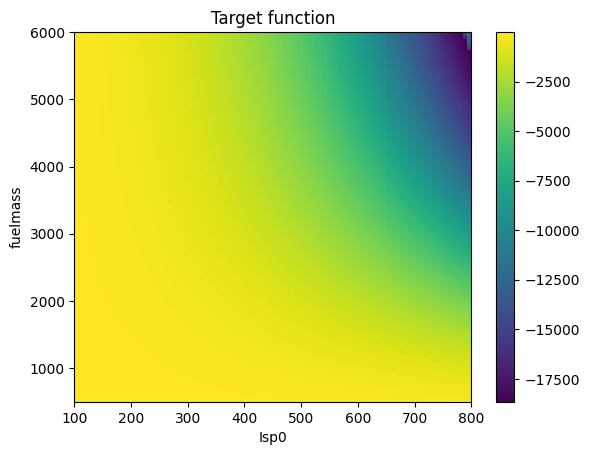

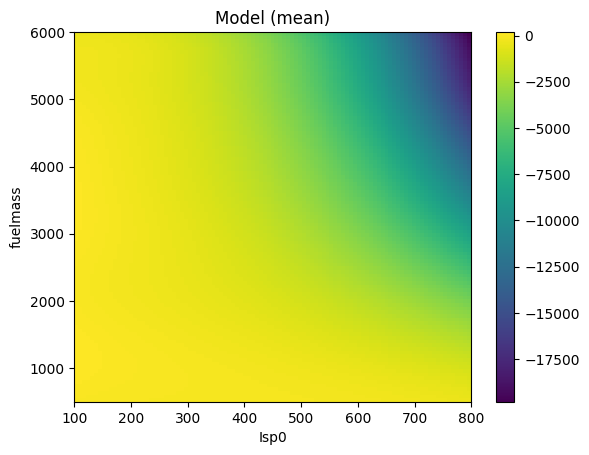

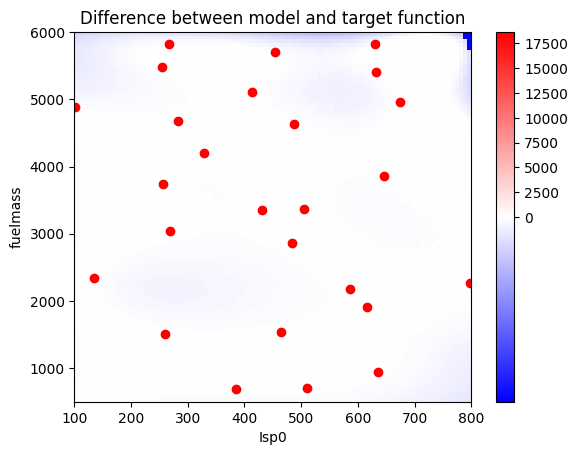

In [31]:
if run_grid_simulation:

#     ## Heatmaps
#     extents = [m2_space.parameters[0].min, m2_space.parameters[0].max, 
#                m2_space.parameters[1].min, m2_space.parameters[1].max]

#     # True values
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_Z, extent=extents, aspect='auto')
#     ax.set_title('Target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()

#     # Model
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred2, extent=extents, aspect='auto')
#     ax.set_title('Model (mean)')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()


#     # Difference
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred2-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm)
#     ax.set_title('Difference between model and target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     ax.plot(np.array(m2_2_model_emukit.X)[:,0], np.array(m2_2_model_emukit.X)[:,1], 'ro')
#     fig.colorbar(im, ax=ax)
#     fig.show()

#     # ax.plot(m2_x, m2_y, marker='o', color='red')
    
    # REVERSE
    ## Heatmaps
    extents = [m2_space.parameters[1].min, m2_space.parameters[1].max, 
               m2_space.parameters[0].min, m2_space.parameters[0].max]

    # True values
    fig, ax = plt.subplots()
    im = ax.imshow(m2_Z, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()

    # Model
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred2, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Model (mean)')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()


    # Difference
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred2-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm, origin='lower')
    ax.set_title('Difference between model and target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    # Add points where simulation evaluated
#     ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
#     ax.plot(m2_x[:,1], m2_x[:,0], 'ro')
    ax.plot(np.array(m2_2_model_emukit.X)[:,1], np.array(m2_2_model_emukit.X)[:,0], 'ro')
    fig.colorbar(im, ax=ax)
    fig.show()



## 2. Maximization


In [32]:
m2_model_gpy = GPRegression(m2_x,m2_y, kernel=m2_kern)
m2_model_gpy.kern.variance =  m2_var_kernel 
m2_model_gpy.likelihood.variance.fix(m2_var_noise)  

m2_model_emukit = GPyModelWrapper(m2_model_gpy)
m2_model_emukit.optimize()


 /Users/ilariasartori/opt/anaconda3/envs/mlphysical/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


In [33]:
# Compute current prediction
m2_mu_plot_grid_pred1, var_plot_grid_pred1 = m2_model_emukit.predict(m2_x_plot)
m2_mu_plot_pred1 = m2_mu_plot_grid_pred1.reshape(m2_x_plot_mesh.shape)
m2_var_plot_pred1 = var_plot_grid_pred1.reshape(m2_x_plot_mesh.shape)

if run_grid_simulation:
    m2_rmse = evaluate_prediction(y_actual=m2_y_plot, y_predicted=m2_mu_plot_grid_pred1)
    print("RMSE m2 (before experiment design loop): ", m2_rmse)



RMSE m2 (before experiment design loop):  4214.514052729341


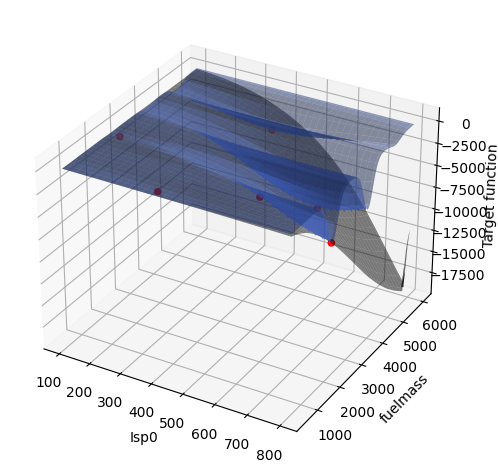

In [34]:
if run_grid_simulation:
    # 3D Plot
    add_bands = False
    
    # REVERSE
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # True surface
    surf = ax.plot_surface(m2_y_plot_mesh, m2_x_plot_mesh, (m2_Z).transpose(), 
                           alpha = .5, 
                           label='target function',
                           color='black'
                          )
    # Mean predicted
    surf = ax.plot_surface(m2_y_plot_mesh, m2_x_plot_mesh, (m2_mu_plot_pred1).transpose(), 
                           alpha = .5, 
                           label='model', # Mean
                           color='royalblue'
                          )
    # True points observed
    ax.scatter(m2_x[:,1], m2_x[:,0], m2_y, marker='o', color='red')

    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    ax.set_zlabel('Target function')
    plt.tight_layout()


 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_8056/1125577198.py:53: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_8056/1125577198.py:62: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_8056/1125577198.py:75: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


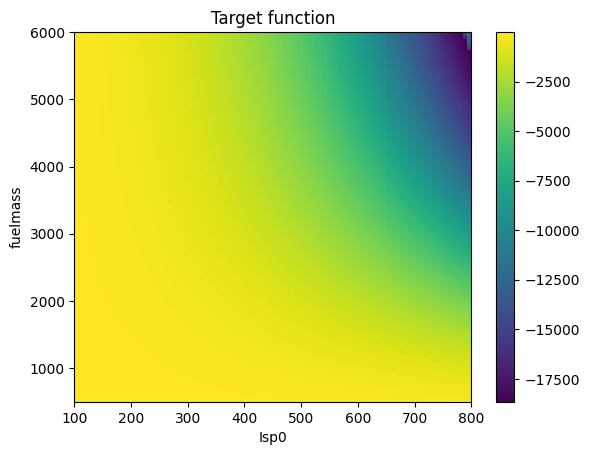

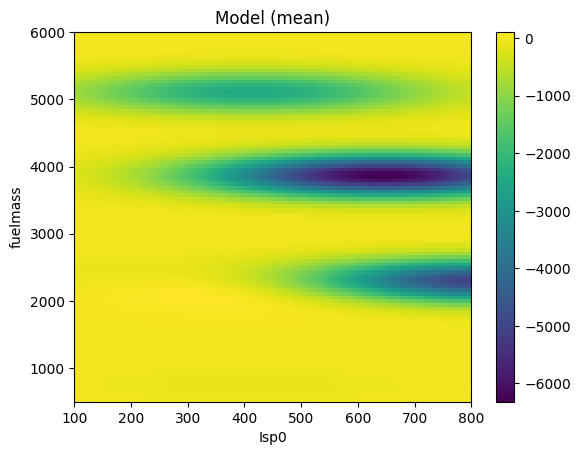

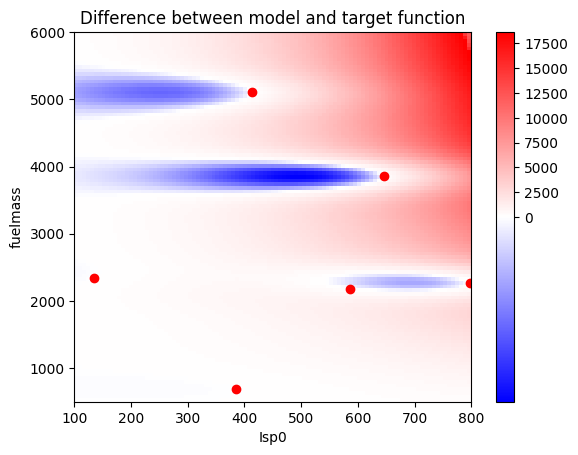

In [35]:
if run_grid_simulation:
    from matplotlib import colors
    divnorm=colors.TwoSlopeNorm(vcenter=0.) # vmin=-5., vcenter=0., vmax=10

#     # NORMAL
#     ## Heatmaps
#     extents = [m2_space.parameters[0].min, m2_space.parameters[0].max, 
#                m2_space.parameters[1].min, m2_space.parameters[1].max]

#     # True values
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_Z, extent=extents, aspect='auto')
#     ax.set_title('Target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()

#     # Model
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred1, extent=extents, aspect='auto')
#     ax.set_title('Model (mean)')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()


#     # Difference
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred1-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm)
#     ax.set_title('Difference between model and target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     # Add points where simulation evaluated
#     ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
# #     ax.plot(m2_x[:,1], m2_x[:,0], 'ro')
#     fig.colorbar(im, ax=ax)
#     fig.show()

    # REVERSE
    ## Heatmaps
    extents = [m2_space.parameters[1].min, m2_space.parameters[1].max, 
               m2_space.parameters[0].min, m2_space.parameters[0].max]

    # True values
    fig, ax = plt.subplots()
    im = ax.imshow(m2_Z, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()

    # Model
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred1, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Model (mean)')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()


    # Difference
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred1-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm, origin='lower')
    ax.set_title('Difference between model and target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    # Add points where simulation evaluated
#     ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
    ax.plot(m2_x[:,1], m2_x[:,0], 'ro')
    fig.colorbar(im, ax=ax)
    fig.show()



### Use the model created for model-based bayes optimization
use the model to decide which are the best points to collect using some data collection criteria (that we call acquisition).

In [46]:
m2_max_model_emukit = m2_model_emukit

In [47]:
# Bayesian optimization using emulator
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

maxim_aquisition = ExpectedImprovement(model=m2_max_model_emukit)


bayesopt_loop = BayesianOptimizationLoop(model = m2_max_model_emukit,
                                         space = m2_space,
                                         acquisition = maxim_aquisition,
                                         batch_size = 1)

max_iterations = 5*2
# def neg_run_missile_sim(custom_params):
#     return -run_missile_sim(custom_params)

bayesopt_loop.run_loop(neg_run_missile_sim, max_iterations) 




New simulation 

fuelmass: 5809.121180872779
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  9.157714484146144
Angle (deg h):  43.660495893429776
Range (km):  677.239760565129
Time (sec):  506.40000000004665
Simulation exceeded time limit.
Final results: 
Range (km):  14808.305550252122
Apogee (km):  24117.006887150692
Time to target (sec):  20000.099999989452



New simulation 

fuelmass: 5583.601267414852
Isp0: 800.0


Stage 1 burnout
Velocity (km/s):  9.042688288525868
Angle (deg h):  43.65505378076317
Range (km):  654.1807361052586
Time (sec):  486.8000000000422
Final results: 
Range (km):  18322.431135212475
Apogee (km):  20881.020993120404
Time to target (sec):  17871.100000020433



New simulation 

fuelmass: 5533.682405318226
Isp0: 661.6187602822297


Stage 1 burnout
Velocity (km/s):  7.284116450543136
Angle (deg h):  43.654660203279256
Range (km):  441.08444263138944
Time (sec):  399.0000000000222
Final results: 
Range (km):  10573.015845743706
Apogee (km):  4828.18557535825


In [48]:
results = bayesopt_loop.get_results()
results



In [49]:
m2_max_model_emukit.X.shape

(21, 2)

In [50]:
m2_max_model_emukit.__dict__

{'model': <GPy.models.gp_regression.GPRegression at 0x7f85d30f4e80>,
 'n_restarts': 1}

In [51]:
if run_grid_simulation:
    # Compute new prediction
    m2_mu_plot_grid_pred2, var_plot_grid_pred2 = m2_max_model_emukit.predict(m2_x_plot)
    m2_mu_plot_pred2 = m2_mu_plot_grid_pred2.reshape(m2_x_plot_mesh.shape)
    m2_var_plot_pred2 = var_plot_grid_pred2.reshape(m2_x_plot_mesh.shape)
    
    m2_max_rmse = evaluate_prediction(y_actual=m2_y_plot, y_predicted=m2_mu_plot_grid_pred2)
    print("RMSE m2 (post bayes opt loop): ", m2_max_rmse)




RMSE m2 (post bayes opt loop):  1261.455995639517


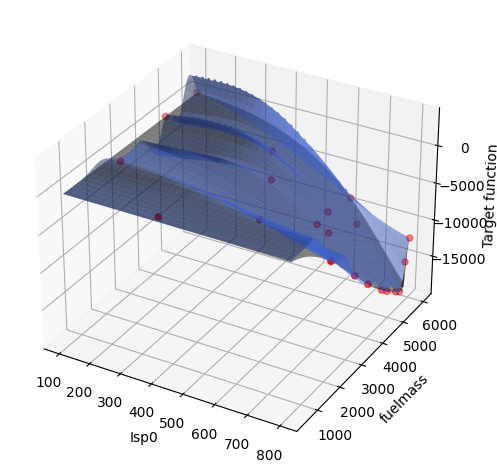

In [52]:
if run_grid_simulation:
    # 3D Plot
    add_bands = False

    
    # REVERSE
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # True surface
    surf = ax.plot_surface(m2_y_plot_mesh, m2_x_plot_mesh, (m2_Z).transpose(), 
                           alpha = .5, 
                           label='target function',
                           color='black'
                          )
    # Mean predicted
    surf = ax.plot_surface(m2_y_plot_mesh, m2_x_plot_mesh, (m2_mu_plot_pred2).transpose(), 
                           alpha = .5, 
                           label='model', # Mean
                           color='royalblue'
                          )
    # True points observed
    ax.scatter(np.array(m2_max_model_emukit.X)[:,1], 
               np.array(m2_max_model_emukit.X)[:,0], m2_max_model_emukit.Y, marker='o', color='red')

    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    ax.set_zlabel('Target function')
    plt.tight_layout()



 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_8056/3906114016.py:50: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_8056/3906114016.py:59: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
 /var/folders/98/fv11ygzs4p51c21s8jln0jzc0000gn/T/ipykernel_8056/3906114016.py:73: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


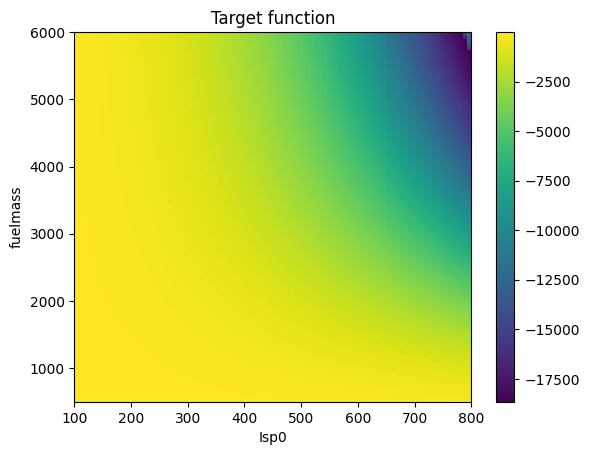

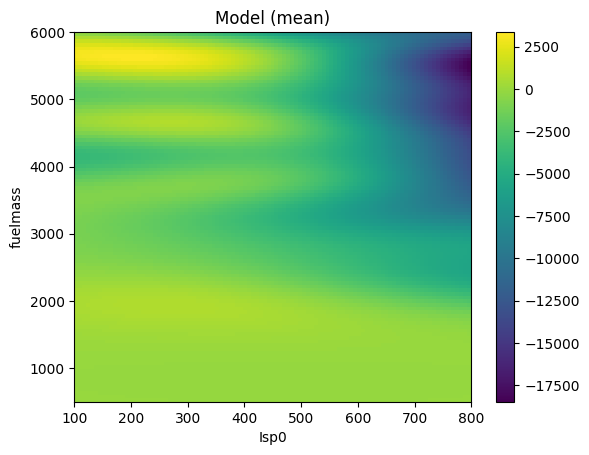

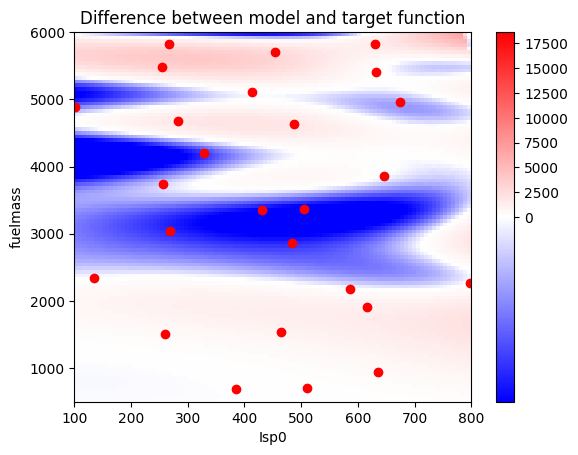

In [53]:
if run_grid_simulation:

#     ## Heatmaps
#     extents = [m2_space.parameters[0].min, m2_space.parameters[0].max, 
#                m2_space.parameters[1].min, m2_space.parameters[1].max]

#     # True values
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_Z, extent=extents, aspect='auto')
#     ax.set_title('Target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()

#     # Model
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred2, extent=extents, aspect='auto')
#     ax.set_title('Model (mean)')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     fig.colorbar(im, ax=ax)
#     fig.show()


#     # Difference
#     fig, ax = plt.subplots()
#     im = ax.imshow(m2_mu_plot_pred2-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm)
#     ax.set_title('Difference between model and target function')
#     ax.set_xlabel(m2_param_1)
#     ax.set_ylabel(m2_param_2)
#     ax.plot(np.array(m2_2_model_emukit.X)[:,0], np.array(m2_2_model_emukit.X)[:,1], 'ro')
#     fig.colorbar(im, ax=ax)
#     fig.show()

#     # ax.plot(m2_x, m2_y, marker='o', color='red')
    
    # REVERSE
    ## Heatmaps
    extents = [m2_space.parameters[1].min, m2_space.parameters[1].max, 
               m2_space.parameters[0].min, m2_space.parameters[0].max]

    # True values
    fig, ax = plt.subplots()
    im = ax.imshow(m2_Z, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()

    # Model
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred2, extent=extents, aspect='auto', origin='lower')
    ax.set_title('Model (mean)')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    fig.colorbar(im, ax=ax)
    fig.show()


    # Difference
    fig, ax = plt.subplots()
    im = ax.imshow(m2_mu_plot_pred2-m2_Z, extent=extents, aspect='auto', cmap="bwr", norm=divnorm, origin='lower')
    ax.set_title('Difference between model and target function')
    ax.set_xlabel(m2_param_2)
    ax.set_ylabel(m2_param_1)
    # Add points where simulation evaluated
#     ax.plot(m2_x[:,0], m2_x[:,1], 'ro')
#     ax.plot(m2_x[:,1], m2_x[:,0], 'ro')
    ax.plot(np.array(m2_2_model_emukit.X)[:,1], np.array(m2_2_model_emukit.X)[:,0], 'ro')
    fig.colorbar(im, ax=ax)
    fig.show()



In [54]:
## Greedy maximization using the simulator
# # opt 1
from collections import namedtuple
Min_val = namedtuple('Min_val', 'fun x')
min_idx = np.argmin(m2_y_plot)
true_minim = Min_val( m2_y_plot[min_idx], m2_x_plot[min_idx])

print("True min value: ", m2_y_plot[min_idx])
print("True min location: ", m2_x_plot[min_idx])

# # # opt2
# nr_custom_params = 2
# wirte_output_txt = False
# from scipy.optimize import minimize


# # func_to_minimize = lambda x: (x[0] - 1)**2 + (x[1] - 2.5)**2  
# def func_to_minimize(x):
#     print(x)
#     return neg_run_missile_sim(np.array(x).reshape(1,nr_custom_params))

# # Function taking 6 inputs and returning the -range of the simulation run with those 6 params and 
# # the others set as defaut
# bnds = [(m2_domain_param_1),
#         (m2_domain_param_2),
# #         (m3_domain_param_3),
# #         (m3_domain_param_4),
# #         (m3_domain_param_5),
# #         (m3_domain_param_6)
#        ]


# initial_guess = [np.mean(m2_domain_param_1),
#                  np.mean(m2_domain_param_2),
# #                  np.mean(m3_domain_param_3),
# #                  np.mean(m3_domain_param_4),
# #                  np.mean(m3_domain_param_5),
# #                  np.mean(m3_domain_param_6)
#                 ]
# true_minim = minimize(func_to_minimize, initial_guess, bounds=bnds) # , method='SLSQP'constraints=cons



True min value:  [-18655.879905]
True min location:  [5725.  800.]


In [55]:
min_val_from_sim = true_minim.fun
min_loc_from_sim = true_minim.x
min_val_from_emu = results.minimum_value
min_loc_from_emu = results.minimum_location

min_val_diff = min_val_from_sim - min_val_from_emu
min_loc_diff = min_loc_from_sim - min_loc_from_emu

print("Min val from sim - min val from em: \n", min_val_diff)
print('\n')
print("Min location from sim - min location from em: \n", min_loc_diff)
print('\n')
print('\n')
print("Min location from sim: \n", min_loc_from_sim)
print("Min location from emu: \n", min_loc_from_emu)
print('\n')
print('\n')
print("Min value from sim: \n", min_val_from_sim)
print("Min value from emu: \n", min_val_from_emu)

Min val from sim - min val from em: 
 [-334.20675011]


Min location from sim - min location from em: 
 [141.39873259   0.        ]




Min location from sim: 
 [5725.  800.]
Min location from emu: 
 [5583.60126741  800.        ]




Min value from sim: 
 [-18655.879905]
Min value from emu: 
 -18321.673154885702
